# Homework 2 - Two Band Equaliser Design

### Bernard Spiegl - 1023112

## Description
---

Our goal is to implement a two band equaliser for bass/treble tone control using two first-order shelving filters.
<br>
We will achieve this by implementing a low-frequency shelving filter cascaded (followed) by a high-frequency shelving filter. 

## Imports
---

In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.io import wavfile
import IPython.display as ipd

## Low Shelf Filter
---
First we are going to implement a first order, low-frequency shelving filter whose transfer function is given by the following formula:
$$H_{LS}(z)=\frac{Gtan(\omega_c/2)+\sqrt{G}+\Big[Gtan(\omega_c/2)-\sqrt{G}\Big]z^{-1}}{tan(\omega_c/2)+\sqrt{G}+\Big[tan(\omega_c/2)-\sqrt{G}\Big]z^{-1}}$$
Here $G$ represents gain and $\omega_c$ is the angular crossover frequency. 
<br>
To obtain $\omega_c$ in rad/s we can convert crossover frequency $f_c$ given in Hz using $\omega_c = 2\pi\frac{f_c}{f_s}$ where $f_s$ is the sampling frequency, 44.1 kHz in our case.
Using the transfer function we can obtain filter coefficients. By dividing both numerator and denominator with $a_0=tan(\omega_c/2)+\sqrt{G}$ we get:
$$a_0 = 1$$
$$  a_1 = \frac{tan(\omega_c/2)-\sqrt{G}}{tan(\omega_c/2)+\sqrt{G}} $$
$$  b_0 = \frac{Gtan(\omega_c/2)+\sqrt{G}}{tan(\omega_c/2)+\sqrt{G}} $$
$$  b_1 = \frac{Gtan(\omega_c/2)-\sqrt{G}}{tan(\omega_c/2)+\sqrt{G}} $$

### Block Diagram

### Implementation

In [2]:
def low_shelf(G, fc, fs=44100):
    G = np.power(10, G / 20)
    b = np.ones(2)
    a = np.ones(2)
    
    omega = 2 * np.pi * fc / fs
    tan_f = np.tan(omega / 2)
    sqrt_G = np.sqrt(G)
    a0 = tan_f + sqrt_G
    
    b[0] = (G * tan_f + sqrt_G) / a0
    b[1] = (G * tan_f - sqrt_G) / a0
    a[1] = (tan_f - sqrt_G) / a0
    
    return b, a

### Magnitude Response

We are now able to plot the magnitude response of our shelving filter.
<br>
To see how the filter performs at different gains we can fix the crossover frequency $f_c=10^3$ Hz and change gain $G$ between -12 dB and 12 dB with 4 dB step size.

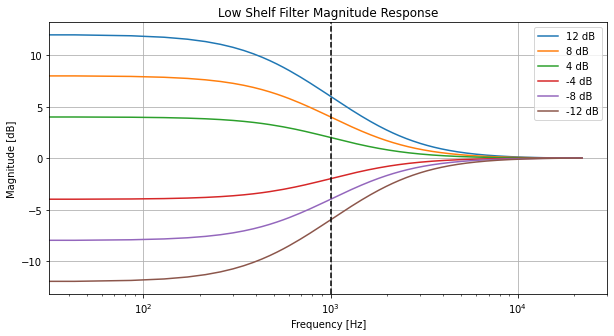

In [3]:
plt.figure(figsize=(10, 5))

crossover_freq = 1e3

for gain in range(12, -13, -4):
    if gain == 0:
        continue
    b_low, a_low = low_shelf(gain, crossover_freq)
    w, h_low = signal.freqz(b_low, a_low, fs=44100)
    plt.plot(w, 20 * np.log10(np.abs(h_low)))

plt.grid()
plt.xscale("log")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.title("Low Shelf Filter Magnitude Response")
plt.axvline(crossover_freq, color="black", linestyle="--")
plt.legend([f"{gain} dB" for gain in range(12, -13, -4) if gain != 0])
plt.show()

## High Shelf Filter
---

Now we need to implement a high-frequency first order shelving filter, the transfer function is given as follows:
$$H_{HS}(z)=\frac{\sqrt{G}tan(\omega_c/2)+G+\Big[\sqrt{G}tan(\omega_c/2)-G\Big]z^{-1}}{\sqrt{G}tan(\omega_c/2)+1+\Big[\sqrt{G}tan(\omega_c/2)-1\Big]z^{-1}}$$
We obtain this transfer function by taking the low-frequency shelving filter transfer function and replacing the gain $G$ with $1/G$ to get an inverse filter and then multiply the transfer function by $G$ to shift the magnitude response so that the gain at the zero frequency is 0 dB, and higher gain is achieved as desired. Hereafter, the numerator and the denominator are multiplied by $\sqrt{G}$ to cancel divisions by $G$.

### Block Diagram

### Impementation

In [4]:
def high_shelf(G, fc, fs=44100):
    G = np.power(10, G / 20)
    b = np.ones(2)
    a = np.ones(2)
    
    omega = 2 * np.pi * fc / fs
    tan_f = np.tan(omega / 2)
    sqrt_G = np.sqrt(G)
    a0 = sqrt_G * tan_f + 1
    
    b[0] = (sqrt_G * tan_f + G) / a0
    b[1] = (sqrt_G * tan_f - G) / a0
    a[1] = (sqrt_G * tan_f - 1) / a0
    
    return b, a

### Magnitude Response 

We can once again plot the magnitude response of our shelving filter using the previously explained method.
<br>
We can now see that the high-frequency shelving filter magnitude response is equal to the low-frequency one flipped horizontally w.r.t. crossover frequency $f_c$.

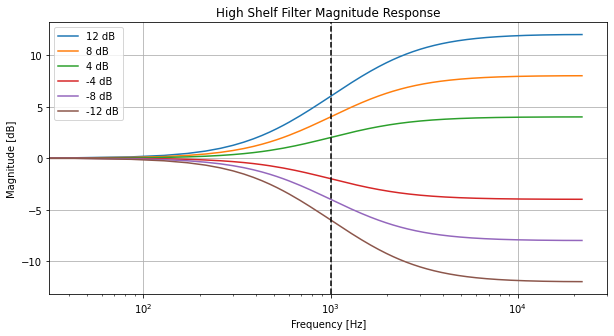

In [5]:
plt.figure(figsize=(10, 5))

crossover_freq = 1e3

for gain in range(12, -13, -4):
    if gain == 0:
        continue
    b_high, a_high = high_shelf(gain, crossover_freq)
    w, h_high = signal.freqz(b_high, a_high, fs=44100)
    plt.plot(w, 20 * np.log10(np.abs(h_high)))

plt.grid()
plt.xscale("log")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.title("High Shelf Filter Magnitude Response")
plt.axvline(crossover_freq, color="black", linestyle="--")
plt.legend([f"{gain} dB" for gain in range(12, -13, -4) if gain != 0])
plt.show()

##  EQ
---
With these two filters designed, we are able to cascade them in order to create a two band equaliser.

![](eq-block.png)


### Cascading the Filters - Magnitude Response

Here we can see what happens when we cascade (combine) the two created filters.
<br>
It is particularly interesting that when using the same GLP and GHP values in combination with same crossover frequency, the ultimate (EQ) magnitude response is flat.

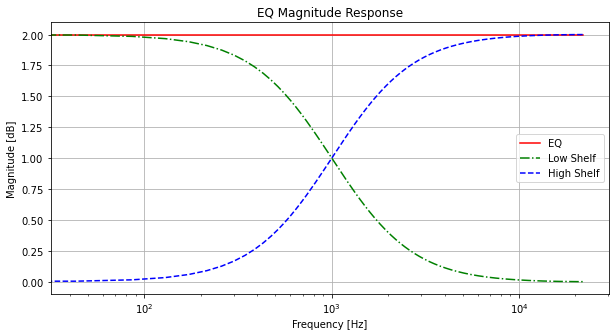

In [6]:
plt.figure(figsize=(10, 5))

b_low, a_low = low_shelf(2, 1000)
b_high, a_high = high_shelf(2, 1000)

w, h_low = signal.freqz(b_low, a_low, fs=44100)
w, h_high = signal.freqz(b_high, a_high, fs=44100)
h = h_low * h_high # cascaded frequency response - multiplication of individual responses


plt.grid()
plt.xscale("log")
plt.plot(w, 20 * np.log10(np.abs(h)), "r")
plt.plot(w, 20 * np.log10(np.abs(h_low)), "g-.")
plt.plot(w, 20 * np.log10(np.abs(h_high)), "b--")
plt.legend(["EQ", "Low Shelf", "High Shelf"])
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude [dB]")
plt.title("EQ Magnitude Response")
plt.show()

### EQ Implementation

Now we can fully wrap everything created and implement our EQ as a class which can then be used to equalize an input signal.

In [7]:
class EQ:
    def __init__(self, glp, ghp, cross_l, cross_h, fs=44100):

        self.fs = fs
        self.b_low, self.a_low = self._low_shelf(glp, cross_l)
        self.b_high, self.a_high = self._high_shelf(ghp, cross_h)
    
    def _low_shelf(self, G, fc):
        G = np.power(10, G / 20)
        b = np.ones(2)
        a = np.ones(2)

        omega = 2 * np.pi * fc / self.fs
        tan_f = np.tan(omega / 2)
        sqrt_G = np.sqrt(G)
        a0 = tan_f + sqrt_G

        b[0] = (G * tan_f + sqrt_G) / a0
        b[1] = (G * tan_f - sqrt_G) / a0
        a[1] = (tan_f - sqrt_G) / a0

        return b, a
    
    def _high_shelf(self, G, fc):
        G = np.power(10, G / 20)
        b = np.ones(2)
        a = np.ones(2)

        omega = 2 * np.pi * fc / self.fs
        tan_f = np.tan(omega / 2)
        sqrt_G = np.sqrt(G)
        a0 = sqrt_G * tan_f + 1

        b[0] = (sqrt_G * tan_f + G) / a0
        b[1] = (sqrt_G * tan_f - G) / a0
        a[1] = (sqrt_G * tan_f - 1) / a0

        return b, a
    
    def apply(self, sig_in):
        return signal.lfilter(self.b_high, self.a_high, signal.lfilter(self.b_low, self.a_low, sig_in))
    
    def plot_mag_resp(self):
        plt.figure(figsize=(10, 5))
        
        w, h_low = signal.freqz(self.b_low, self.a_low, fs=self.fs)
        w, h_high = signal.freqz(self.b_high, self.a_high, fs=self.fs)
        h = h_low * h_high


        plt.grid()
        plt.xscale("log")
        plt.plot(w, 20 * np.log10(np.abs(h)), "r")
        plt.plot(w, 20 * np.log10(np.abs(h_low)), "g-.")
        plt.plot(w, 20 * np.log10(np.abs(h_high)), "b--")
        plt.legend(["EQ", "Low Shelf", "High Shelf"])
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Magnitude [dB]")
        plt.title("EQ Magnitude Response")
        plt.show()

### Test

We are now able to test our EQ implementation by loading an audio example and applying different EQs to it.
<br>
First, we can load the original audio file to know what we are compairing against.

In [8]:
sr, data = wavfile.read("example.wav")
data = data.sum(axis=1) / 2

ipd.Audio(data, rate=sr)

#### Boosting Bass

We create the first filter with GLP = 6 dB, GHP = -3 dB and a 1 kHz crossover frequency.
<br>
We are able to hear that the low end is slightly boosted and high end attenuated when comparing to the original - which is also visible in the magnitude response.

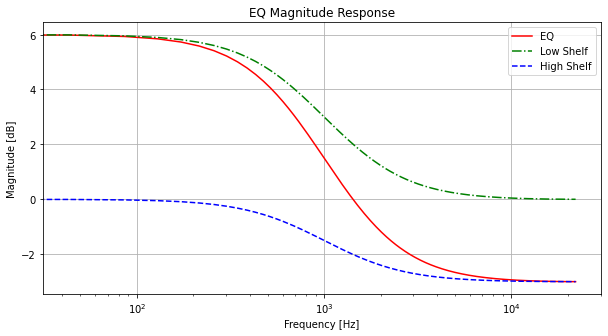

In [9]:
eq = EQ(6, -3, 1e3, 1e3)
eq.plot_mag_resp()

ipd.Audio(eq.apply(data), rate=sr)

Now we can try an even more extreme setting by sliding the crossover frequency more to the right in both filters and simultaneously increasing GLP and decreasing GLH, respectively.
<br>
Here, the difference is even more clear as the low end clearly stands out.

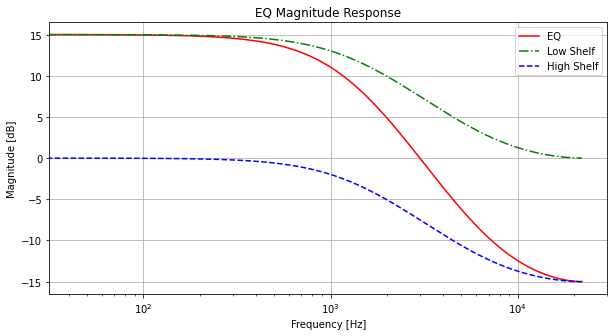

In [10]:
eq2 = EQ(15, -15, 3e3, 3e3)
eq2.plot_mag_resp()

ipd.Audio(eq2.apply(data), rate=sr)

#### Boosting Treble

It is also possible to perform treble boosting by swapping values of GLP and GHP from previous examples.

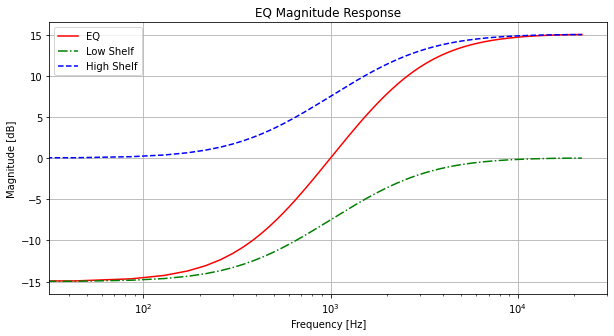

In [11]:
eq3 = EQ(-15, 15, 1e3, 1e3)
eq3.plot_mag_resp()

ipd.Audio(eq3.apply(data), rate=sr)

## References
---


[1] Välimäki, V.; Reiss, J.D. All About Audio Equalization: Solutions and Frontiers. Appl. Sci. 2016, 6, 129. https://doi.org/10.3390/app6050129 